In [1]:
# Import necessary libraries
import torch.cuda as torch_cuda
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [2]:
print('===VERIFY GPU===')
print('CUDA IS AVAILABLE:', torch_cuda.is_available())
print('DEVICE COUNT:', torch_cuda.device_count())
print('DEVICE NAME:', torch_cuda.get_device_name(0))

# If CUDA is available, print GPU details
if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0)} bytes")
    print(f"GPU Memory Cached: {torch.cuda.memory_reserved(0)} bytes")

# Select device: GPU if available, otherwise CPU
device = torch.device('cuda:0' if torch_cuda.is_available() else 'cpu')


===VERIFY GPU===
CUDA IS AVAILABLE: False
DEVICE COUNT: 1


/home/campus.ncl.ac.uk/c1014695/miniconda3/envs/pytorch/lib/python3.13/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

## Training Data

In [ ]:
# Define hyperparameters
batch_size = 16

# Define transformations: Convert to tensor and normalize
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

mnist_trainset = datasets.MNIST(
    root='../Data',
    train=True,
    download=True,
    transform=transformations
)

mnist_testset = datasets.MNIST(
    root='../Data',
    train=False,
    download=True,
    transform=transformations
)

trainloader = DataLoader(
    mnist_trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = DataLoader(
    mnist_testset,
    batch_size=batch_size,
    shuffle=False,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


TRAIN SET LENGTH: 60000
TEST SET LENGTH: 10000


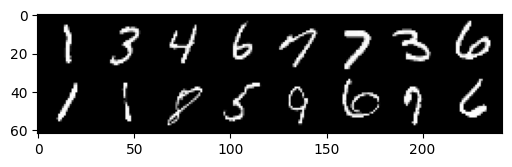

In [ ]:
print('TRAIN SET LENGTH:', len(mnist_trainset))
print('TEST SET LENGTH:', len(mnist_testset))

def imshow(img):

    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), vmin=0, vmax=1)
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(make_grid(images))

## MLP

In [ ]:
momentum_coeff = 0.9
learning_rate = 0.01
learning_decay = 10**-9
epochs = 100

# Classes for MNIST digits
classes = (0,1,2,3,4,5,6,7,8,9)

In [ ]:
# Define a multi-layer perceptron (MLP) model
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        # Flatten layer to convert 28x28 images into 784-dim vector
        self.flat = nn.Flatten()

        # Define linear layers
        self.input_layer = nn.Linear(784, 1000)
        self.hidden_layer1 = nn.Linear(1000, 1000)
        self.hidden_layer2 = nn.Linear(1000, 1000)
        self.hidden_layer3 = nn.Linear(1000, 1000)
        self.hidden_layer4 = nn.Linear(1000, 1000)
        self.out = nn.Linear(1000, 10)

        # Define dropout layers
        self.dropout_layer1 = nn.Dropout(p=0.2)
        self.dropout_layer2 = nn.Dropout(p=0.3)
        self.dropout_layer3 = nn.Dropout(p=0.4)
        self.dropout_layer4 = nn.Dropout(p=0.5)

    def forward(self, x, output=5):
        # Flatten the image into a 784-dim vector
        x = x.reshape(-1, 784)

        # Pass through layers with ReLU activation and dropout
        x = F.relu(self.input_layer(x))

        x = F.relu(self.hidden_layer1(x))
        if output == 1:
            return x
        x = self.dropout_layer1(x)
        
        x = F.relu(self.hidden_layer2(x))
        if output == 2:
            return x
        x = self.dropout_layer2(x)
        
        x = F.relu(self.hidden_layer3(x))
        if output == 3:
            return x
        x = self.dropout_layer3(x)
        
        x = F.relu(self.hidden_layer4(x))
        if output == 4:
            return x
        x = self.dropout_layer4(x)
        
        # IMPORTANT FIX: Do not apply softmax here.
        # CrossEntropyLoss expects raw logits.
        x = self.out(x)
        return x  # Return raw logits

# Instantiate and move model to the selected device
mlp = MLP().to(device)

loss_function = nn.CrossEntropyLoss()  # CrossEntropyLoss expects raw logits
optimizer = optim.SGD(mlp.parameters(), lr=learning_rate,
                      momentum=momentum_coeff, weight_decay=learning_decay)


def train(epoch):

    mlp.train()
    for batch_idx, (data, target) in enumerate(trainloader):

        data, target = data.to(device), target.to(device)


        optimizer.zero_grad()

        output = mlp(data, output=5)


        loss = loss_function(output, target)

        loss.backward()

        optimizer.step()

        if batch_idx % 25 == 0:
            print('Train Epoch: {:>3}\t[{:>5}/{:>5} ({:>3.0f}%)]\tLoss: {:>7.6f}'.format(
                epoch + 1, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))


def test():
    mlp.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in testloader:
            # Move data and targets to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = mlp(data, output=5)

            # Compute loss and accumulate
            test_loss += loss_function(output, target).item()

            # Get predicted classes
            pred = output.argmax(dim=1, keepdim=True)

            # Count how many predictions are correct
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Average loss over the entire test set
    test_loss /= len(testloader)

    # Print test performance
    print('\nTest set: Average loss: {:>10.4f}, Accuracy: {:>5}/{:>5} ({:>3.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))


# Run the training and testing for defined epochs
for epoch in range(epochs):
    train(epoch)
    test()


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
torch.save(mlp.state_dict(), '../Saved/MNIST_MLP_TRAINED.pt')

### Get Layer Activations

In [ ]:
def get_activations(layer = 4):
    activations = []
    labels = []
    predictions = []
    with torch.no_grad():
        for data, target in trainloader:
            # Move data and targets to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = mlp(data, output=layer)
            for t in output:
                activations.append(t.to('cpu').numpy())
            labels.append(target.to('cpu').numpy())

            output = mlp(data, output=5)
            for t in output:
                pred = np.argmax(t.to('cpu').numpy())
                predictions.append(pred)


        for data, target in testloader:
            # Move data and targets to device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = mlp(data, output=layer)
            for t in output:
                activations.append(t.to('cpu').numpy())
            labels.append(target.to('cpu').numpy())

            output = mlp(data, output=5)
            for t in output:
                pred = np.argmax(t.to('cpu').numpy())
                predictions.append(pred)

    return activations, labels, predictions

activations, labels, predictions = get_activations(4)

In [ ]:
activations = np.array(activations)

predictions_df = pd.DataFrame(predictions, columns=['prediction'])
labels_df = pd.DataFrame(np.array(labels).flatten(), columns=['class'])
labels_df.head()

,class
0,6
1,0
2,5
3,5
4,4


### Dimensionality Reduction

In [ ]:
from sklearn.manifold import TSNE

dim_red = TSNE(n_components = 2, random_state=0)
points = dim_red.fit_transform(activations)
points

array([[ -61.928658,  -60.039845],
       [  92.199554,   20.279886],
       [ -62.602047,   30.635954],
       ...,
       [ -35.807014, -100.672035],
       [ -68.270096,   21.23432 ],
       [ -81.84676 ,  -52.00975 ]], dtype=float32)

### Quick Plot

<Axes: xlabel='x', ylabel='y'>

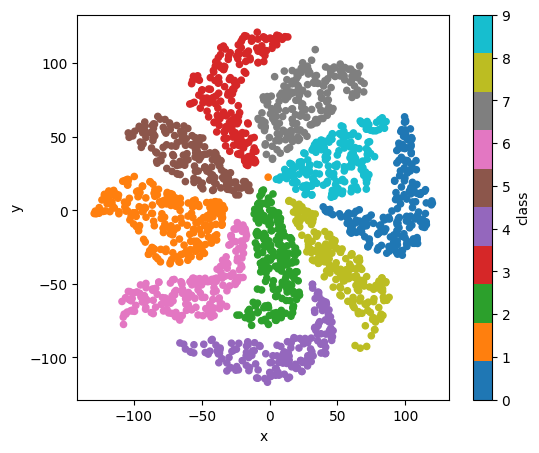

In [ ]:
# Quick plot to check data
points_df = pd.DataFrame(points, columns=['x','y']).join(labels_df).join(predictions_df)

plt.rcParams["figure.figsize"] = [6, 5]
points_df[0:2000].plot.scatter(
    x='x',
    y='y',
    c='class',
    colormap='tab10'
)

In [ ]:
points_df.to_csv('../Outputs/MNIST_MLP_LAYER_4_WITH_PREDICTIONS.csv', index=False)

In [ ]:
points_df.head()

,x,y,class,prediction
0,-61.928658,-60.039845,6,6
1,92.199554,20.279886,0,0
2,-62.602047,30.635954,5,5
3,-65.543907,53.727707,5,5
4,10.861479,-111.375496,4,4
